# 1) Loading datasets & splitting normal conditions into train & test

In [283]:
import numpy as np
from sklearn.model_selection import train_test_split

normal = np.genfromtxt('HW3 datasets/powerline_normal.csv', delimiter=',', dtype=np.float_)[1:, 1:]
anomalous = np.genfromtxt('HW3 datasets/powerline_anomaly.csv', delimiter=',', dtype=np.float_)[1:, 1:]

train, test = train_test_split(normal, test_size=0.2, random_state=42)

# 2) Combining test dataset with anomalous conditions dataset

In [284]:
labels = np.array([0]*len(test)+[1]*len(anomalous), dtype=np.float_)
test = np.concatenate((test, anomalous), axis=0)

# 3) Train a Gaussian Mixture model on training dataset

In [285]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(train)
gm = GaussianMixture(n_components=5, random_state=0).fit(sc.transform(train))

# 4) Use the trained model to classify test set

In [286]:
from scipy.stats import norm

test_gm = gm.score_samples(sc.transform(test))

test_exp = np.exp(test_gm).reshape(-1, 1)
test_norm = StandardScaler().fit_transform(test_exp).reshape(-1)
z_thresh = -norm.ppf(0.05)   # 5% density threshold

test_pred = test_exp < z_thresh

# 5) Reporting the Results of the model

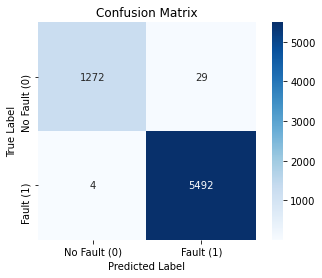

In [287]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = test_pred
y_test = labels

conf_mat = confusion_matrix(y_test, y_pred)

lang = ['No Fault (0)', 'Fault (1)']
ax = plt.axes()
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, ax=ax, xticklabels=lang, yticklabels=lang)
ax.set_title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [288]:
true_positive = conf_mat[1, 1]
true_negative = conf_mat[0, 0]
false_positive = conf_mat[0, 1]
false_negative = conf_mat[1, 0]
accuracy = accuracy_score(y_pred, y_test)

print("The Evaluation Metrics of the Gaussian Mixture model with 5 components & 5% density threshold (on the test set) is as follows:\n")

print("True Positives:", true_positive)
print("True Negatives:", true_negative)
print("False Positives:", false_positive)
print("False Negatives:", false_negative, end='\n\n')

print("Precision:", true_positive/(true_positive+false_positive))
print("Recall:", true_positive/(true_positive+false_negative), end='\n\n')

print("Accuracy:", accuracy)

The Evaluation Metrics of the Gaussian Mixture model with 5 components & 5% density threshold (on the test set) is as follows:

True Positives: 5492
True Negatives: 1272
False Positives: 29
False Negatives: 4

Precision: 0.9947473283825394
Recall: 0.9992721979621543

Accuracy: 0.995144916875092


# 6) Performing Grid Search on no. of components & density threshold

In [289]:
sc = StandardScaler()
norm_train = sc.fit_transform(train)
norm_test = sc.transform(test)

def evaluate_model(n_components, thresh, norm_train, norm_test, test_labels):
    gm = GaussianMixture(n_components=n_components, random_state=0).fit(norm_train)
    test_gm = gm.score_samples(norm_test)
    
    test_exp = np.exp(test_gm).reshape(-1, 1)
    test_norm = StandardScaler().fit_transform(test_exp).reshape(-1)
    z_thresh = -norm.ppf(thresh)
    test_pred = test_exp < z_thresh
    
    return accuracy_score(test_pred, test_labels), test_pred

In [290]:
# Perfroming Grid Search & Finding best model
import pandas as pd

accuracy_table = []
best_accuracy = 0
best_ncomp = -1
best_thresh = -1
best_pred = []

for n_comp in range(1, 11):
    accuracy_table.append([])
    for thresh in [0.001, 0.005, 0.01, 0.02, 0.05, 0.5]:
        thresh = round(thresh, 2)
        accuracy, pred = evaluate_model(5, thresh, norm_train, norm_test, labels)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_pred = pred
            best_ncomp = n_comp
            best_thresh = thresh
        
        accuracy_table[-1].append(round(accuracy, 4))

accuracy_table = pd.DataFrame(accuracy_table, columns=['0.1%', '0.5%', '1%', '2%', '5%', '50%'], index=range(1, 11))

print("Accuracy Table (Row: n_components | Col: threshold):")
accuracy_table.head(10)

Accuracy Table (Row: n_components | Col: threshold):


,0.1%,0.5%,1%,2%,5%,50%
1,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
2,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
3,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
4,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
5,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
6,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
7,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
8,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
9,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914
10,0.8086,0.9954,0.9954,0.9954,0.9951,0.1914


# 7) Finding and Evaluating the Best Model:

In [291]:
print("The Best accuracy was obtained with the following configuration:")
print("No. of Components:", best_ncomp)
print("Density Threshold:", best_thresh*100, "%")
print("Accuracy:", best_accuracy)

The Best accuracy was obtained with the following configuration:
No. of Components: 1
Density Threshold: 1.0 %
Accuracy: 0.9954391643372076


The Evaluation of the Best Model is as follows:


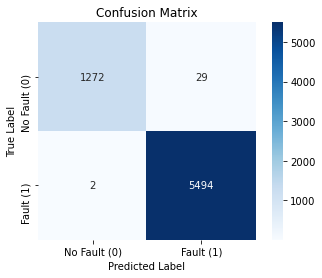

In [292]:
print("The Evaluation of the Best Model is as follows:")
y_pred = best_pred

conf_mat = confusion_matrix(y_test, y_pred)

lang = ['No Fault (0)', 'Fault (1)']
ax = plt.axes()
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, ax=ax, xticklabels=lang, yticklabels=lang)
ax.set_title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [293]:
true_positive = conf_mat[1, 1]
true_negative = conf_mat[0, 0]
false_positive = conf_mat[0, 1]
false_negative = conf_mat[1, 0]
accuracy = accuracy_score(y_pred, y_test)

print("The Evaluation Metrics of the Gaussian Mixture model with the Best Configuration (on the test set) is as follows:\n")

print("True Positives:", true_positive)
print("True Negatives:", true_negative)
print("False Positives:", false_positive)
print("False Negatives:", false_negative, end='\n\n')

print("Precision:", true_positive/(true_positive+false_positive))
print("Recall:", true_positive/(true_positive+false_negative), end='\n\n')

print("Accuracy:", accuracy)

The Evaluation Metrics of the Gaussian Mixture model with the Best Configuration (on the test set) is as follows:

True Positives: 5494
True Negatives: 1272
False Positives: 29
False Negatives: 2

Precision: 0.9947492304906753
Recall: 0.9996360989810772

Accuracy: 0.9954391643372076


# Inference:

The following are the points to be noted about the choice of the best model:<br>
- The best model was chosen based on the accuracy of it's classification on the test set.<br>
- The best model was found to be using a single gaussian distribution with 1% as the density threshold, giving an outstanding accuracy of 99.54%.<br>
- It is to be noted that, the accuracy is so high, possibly since, there is a huge variance between the attributes of the attributes (readings) when a Fault was present vs No Fault.<br>
- In fact, due to this huge variance there isn't a huge difference between the accuracy of models when the threshold was changes between 0.5% to 5%, and it did not change too much with respect to the number of components too.<br>
- But however when a huge change in the threshold was made, such as 50%, then the accuracy drastically dropped to less than 20%. This suggests that a huge amount of anomalous data was clustered together, yet far away from the normal data.<br>
- So finally the best model (although it didn't have a huge difference compared to the close runner ups), was found to have a better precision, recall values, with just 2 false negatives in the 5% threshold with n_comp=5 model, being correctly classified as true negatives, causing it to be chosen as the best model of all.